## Debias Convex Algorithm

### Input:

- O: the observation
- Z: the treatment pattern
- $\lambda$: the parameter for nuclear norm

### Output:
The goal is to minimize
$$
\min_{M,\tau} \frac{1}{2p}\|P_{\Omega}(O-M-\tau Z)\|_{F}^2 + \lambda \| M\|_{*} 
$$

We do this by implementing an iterative algorithm:

- $M_0 = 0, \tau_0 = 0, t = 0$
- $t = t + 1$
- $M_t = \text{soft\_thresholding}(O-\tau Z, \lambda)$ 
- $\tau_{t} = <Z,O-M_t>/\|Z\|_{F}^2$
- Until $|\tau_{t} - \tau_{t-1}| < 1e-3$

## MC-NNM (Bayati etc. 2016 algorithm)

### View treatment as missing entries, then use convex optimization

### Input:
        
- O: the observation
- Ω: the set of no-treatment (Ω = 1 - Z)
- l: the parameter for nuclear norm minimization

### Output:

#### Without fixed effects

solve the optimization:
Let p be the observation probability: $ p =|\Omega| / \text{np.size}(O)$,
\begin{align}
\min_{M} \frac{1}{2p} \|P_{\Omega}(O-M)\|_{F}^2 + \lambda \|M\|_{*}
\end{align}

We do this by iteration (soft_impute)

- $M_0 = 0$
- $M_t = \text{soft_thresholding}(Ω*O + (1-Ω)*M, \lambda * p)$

After convergence, obtaining $M$, Let
$$
\tau = <1-Ω, O-M> / \|1-Ω\|_{F}^2
$$

#### With fixed effects

solve the optimization
\begin{align}
\min_{M} \frac{1}{2p} \|P_{\Omega}(O - a1^{T} - 1b^{T} - M)\|_{F}^2 + \lambda \|M\|_{*}
\end{align}

We do this by:

- $M_0 = 0, a^0 = 0, b^0 = 0$
- fix $a^t, b^t$, solve $M_t = \text{soft_thresholding}(Ω*(O-a^t1^{T}-1b^{tT}) + (1-Ω)*M, \lambda * p)$
- fix $M_t$, solve the following convex optimization
$$
\min_{a \in R^{n}, b \in R^{n}} \sum_{(i,j)\in \Omega} (O_{ij}-M_{t,ij} - a_{i} - b_{j})^2
$$

we solve the above by iteration again (one may change to solve a linear system by considering the first-order condition, not sure which one is quicker)
- fix $b$, 
$$ 
a_i = \frac{\sum_{j, (i,j) \in \Omega} O_{ij} - M_{t,ij} - b_{j}}{\sum_{j, (i, j) \in \Omega} 1}
$$
- fix $a$
$$
b_j = \frac{\sum_{i, (i,j) \in \Omega} O_{ij} - M_{t,ij} - a_{i}}{\sum_{i, (i, j) \in \Omega} 1}
$$


## Covariance PCA, Xiong and Pelger, 2019

Input the matrix $O \in R^{n\times T}$ and Ω

### Step 1: estimate loadings from covariance matrix

\begin{align}
A_{ij} = \frac{1}{\sum_{k, Ω_{i,k} = Ω_{j,k}=1} 1}\sum_{k, Ω_{i,k} = Ω_{j,k}=1} O_{i,k} \cdot O_{j,k}
\end{align}

U = $\sqrt{n}$ * First r eigenvectors of A, therefore $B \in R^{n\times r}$

### Step 2: regress the factors
Let $Y \in R^{T\times r}$.
\begin{align}
Y_{i,\cdot} = \frac{1}{\sum_{k, Ω_{k,i}=1} 1}\sum_{k, Ω_{k,i}=1} O_{k,i} U_{k,\cdot}  
\end{align}

$M = U \cdot Y^{T}$ is the estimator for $M^{*}$

### Step 3: estimate $\tau$
\begin{align}
\tau = \frac{1}{|Z|_0}<Z, O-M>.
\end{align}

## Robust Synthetic Control Shah etc 2017

## Treatment Pattern Generation

### Block Pattern


### i.i.d Pattern


### Two Segment Pattern

### Adaptive Treatment Pattern

#### Input: lowest_T, lasting_T, M

For each row i, if M(i,j) is the smallest among M(i, j-lowest_T:j) and no treatments on (i, j-lowest_T:j), then start the treatment on M(i,j+1) to M(i,j+lasting_T+1)

In [40]:
def adpative_treatment_pattern(lowest_T, lasting_T, M):
    Z = np.zeros_like(M)
    for i in range(Z.shape[0]):
        j = 0
        #print(i)
        while j < Z.shape[1]:
            flag = 0
            for k in range(1, lowest_T+1):
                if (j-k < 0 or Z[i, j-k]==1 or M[i,j] > M[i,j-k]):
                    flag = 1
                    break

            if (flag == 0):
                for k in range(1, lasting_T+1):
                    if (j+k < Z.shape[1]):
                        Z[i, j+k] = 1
                j += lasting_T + lowest_T
            else:
                j = j + 1
    return Z

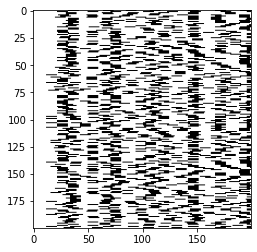

In [75]:
### test adaptive treatment pattern generation

np.random.seed(2)
n1 = 200
n2 = 200
r = 10
mean_M = 20
U = np.random.gamma(shape=1, scale=2, size=(n1, r))
V = np.random.gamma(shape=1, scale=2, size=(n2, r))

def row_normalize(A):
    return (A.T / np.sum(A, axis=1)).T

#U = row_normalize(U)
#V = row_normalize(V)
#print(np.sum(V, axis=1))

M0 = U.dot(V.T)
#M0 = M0 / np.mean(M0) * mean_M #since we take mean here, we want M0 to be positive

# try Gaussian pattern
#sigma = 10
#U = np.random.normal(loc = 0, scale = 1, size=(n1, r))
#V = np.random.normal(loc = 0, scale=2, size=(n2, r))
#M0 = U.dot(V.T)
#M0 = np.random.gamma(shape=1, scale=2, size = (n1, n2))

Z = adpative_treatment_pattern(10, 10, M0)
#print(np.sum(M0, axis=0)-20)
plt.imshow(Z, cmap='Greys')

In [16]:
def error_metric(M, tau, M0, tau_star):
    return np.sum((M - M0)**2) / np.sum(M0**2), np.amax(np.abs(M-M0)) / np.amax(np.abs(M0)), np.abs(tau-tau_star) #/ tau_star

## Check the error distribution of our debias convex algorithm

In [17]:
def projection_T_orthogonal(Z, M):
    u, s, vh = np.linalg.svd(M, full_matrices = False)
    r = np.sum(s >= 1e-5)
    u = u[:, :r]
    vh = vh[:r, :]
    PZ = (np.eye(u.shape[0]) - u.dot(u.T)).dot(Z).dot(np.eye(vh.shape[1]) - vh.T.dot(vh))
    return PZ

def check_distribution(n1, n2, mean_M = 1, tau_star = 1, sigma = 1, r = 20, num_experiment=10, file_path = 'data.p'):
    

    U = np.random.gamma(shape=1, scale=2, size=(n1, r))
    V = np.random.gamma(shape=1, scale=2, size=(n2, r))
    M0 = U.dot(V.T)
    M0 = M0 / np.mean(M0) * mean_M #since we take mean here, we want M0 to be positive

    Z = adpative_treatment_pattern(10, 10, M0)

    Z = np.zeros((n1, n2))
    m1 = 1
    m2 = 20
    Z[:m1, m2:] = 1


    ZTperp = projection_T_orthogonal(Z, M0)
    variance_debias = 1 / np.sum(ZTperp**2)
    variance_ideal = 1 / np.sum(Z**2)
    print(variance_debias, variance_ideal)
    #store 
    data = np.zeros((num_experiment, 8))
    for i in range(num_experiment):
        print('experiments', i)
        E = np.random.normal(loc = 0, scale = sigma, size = (n1, n2))
        #Z = np.random.rand(n, n) <= p_treat
        #Z = np.zeros((n,n))
        #Z[:int(n/2), :int(n/2)] = 1
        
        print('sparsity is ', np.sum(Z) / Z.size)    
        O = M0 + E + Z * tau_star

        u, s, vh = np.linalg.svd(M0 + E, full_matrices = False)
        suggest_lambda = 1.1*s[r]

        M, tau, tau_debias = tune_convex_algorithm_with_rank(O, Z, suggest_r = r, suggest_lambda=suggest_lambda)
        #l = np.sqrt(n)*0.1
        #M, tau = convex_algorithm(O, Z, l)
        M_F, M_oo, tau_error = error_metric(M, tau, M0, tau_star)
        #print('Frobenious error {}, entrywise error {}, tau_error {}'.format(M_F, M_oo, tau_error))
        
        print('tau error {}, tau debias error is {}, ideal error is {}'.format(tau-tau_star, tau_debias - tau_star, ideal_algorithm(E, Z)))
        print('first order tau debias error is {}'.format(np.sum(ZTperp*E)*variance_debias))

        data[i,0] = tau_debias - tau_star
        data[i,1] = ideal_algorithm(E, Z)

    return variance_debias, variance_ideal, data



In [63]:
file_path = 'data.p'
variance_debias, variance_ideal, data = check_distribution(200, 200, mean_M = 20, tau_star = 10, sigma = 1, r = 10, num_experiment = 1000, file_path = file_path)

0.0372831279593228 0.005555555555555556
experiments 0
sparsity is  0.0045
successful 29.59490333649262 10
tau error 1.3511111671827543, tau debias error is 0.1584726248847126, ideal error is 0.04404156737764169
first order tau debias error is 0.15491282749761376
experiments 1
sparsity is  0.0045
successful 29.776219032937334 10
tau error 1.2067793259018949, tau debias error is 0.023348684539055142, ideal error is -0.07500202110685077
first order tau debias error is 0.02508596778542853
experiments 2
sparsity is  0.0045
successful 30.138074215542133 10
tau error 0.9500921139562486, tau debias error is -0.27633132501551216, ideal error is 0.15428363847075852
first order tau debias error is -0.2770910398330379
experiments 3
sparsity is  0.0045
successful 30.397221923814445 10
tau error 1.0611079800399459, tau debias error is -0.16928811679086309, ideal error is 0.03040747229088493
first order tau debias error is -0.1675387092916264
experiments 4
sparsity is  0.0045
successful 30.1104354766

KeyboardInterrupt: 

## Plot the distribution of $\tau^{d}$ and $M^{d}$

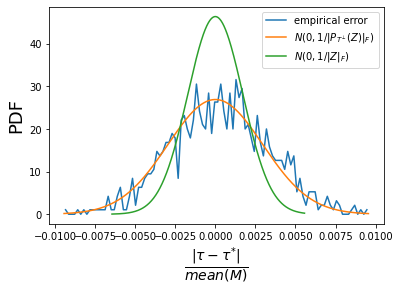

In [76]:
file_path = 'data_2020-11-17-20-47.p'
#pickle.dump([data, variance_debias, variance_ideal], open(file_path, 'wb'))
data, variance_debias, variance_ideal = pickle.load(open(file_path, 'rb'))
data_debias = data[:, 0]
data_ideal = data[:, 1]
mean_M = 5
hist, bined = np.histogram(data_debias, bins = 100, density=True)
plt.plot((bined[:-1]/2+bined[1:]/2)/mean_M, hist)
pos_guassian = np.linspace(min(data_debias), max(data_debias), 1000)
pdf_guassian = norm.pdf(pos_guassian, loc=0, scale=np.sqrt(variance_debias))
plt.plot(pos_guassian/mean_M, pdf_guassian)


#hist, bined = np.histogram(data_ideal, bins = 100, density=True)
#plt.plot(bined[:-1]/2+bined[1:]/2, hist)
pos_guassian = np.linspace(min(data_ideal), max(data_ideal), 1000)
pdf_guassian = norm.pdf(pos_guassian, loc=0, scale=np.sqrt(variance_ideal))
plt.plot(pos_guassian / mean_M, pdf_guassian)

plt.ylabel('PDF', fontsize = 18)
plt.xlabel(r'$\frac{|\tau - \tau^{*}|}{mean(M)}$', fontsize=20)
plt.legend([r'empirical error', r'$N(0, 1/\|P_{T^{\perp}}(Z)\|_{F})$', r'$N(0, 1/\|Z\|_{F})$'])
#plt.show()
#plt.hist(data_ideal, bins = 30)

In [21]:
def synthetic_experiment(n1, n2, mean_M = 1, tau_star = 1, sigma = 1, r = 20, num_experiment=10, file_path = 'data.p', pattern = ''):
    
   #M0 = M0 / np.mean(M0) * mean_M

    #tau_star = mean_M / 10
    p_treat = 0.01

    algo_list = ['tau_convex', 'tau_missing', 'tau_ideal', 'tau_debias', 'tau_PCA']
    if (pattern == 'block'):
        algo_list.append('tau_synthetic_control')
    #store 
    data = np.zeros((num_experiment, len(algo_list)))
    for i in range(num_experiment):
        print('experiments', i)
        while (True):
            U = np.random.gamma(shape=1, scale=2, size=(n1, r))
            V = np.random.gamma(shape=1, scale=2, size=(n2, r))
            M0 = U.dot(V.T)
            M0 = M0 / np.mean(M0) * mean_M #since we take mean here, we want M0 to be positive
            E = np.random.normal(loc = 0, scale = sigma, size = (n1, n2))
            #Z = np.zeros((n,n))
            #Z[:int(n/2), :int(n/2)] = 1
            if (pattern == 'adaptive'):
                Z = adpative_treatment_pattern(10, 10, M0+E)
            else:
                if (pattern == 'iid'):
                    Z = np.random.rand(n1, n2) <= p_treat
                else: 
                    if (pattern == 'block'):
                        Z = np.zeros((n1, n2))
                        m1 = 1
                        m2 = 20
                        Z[:m1, m2:] = 1

            if (np.sum(np.sum(1-Z, axis=0) == 0) > 0 or np.sum(np.sum(1-Z, axis=1) == 0) > 0):
                continue

            u, s, vh = np.linalg.svd(M0 + E, full_matrices = False)
            #print(s)
            suggest_lambda = 1.1*s[r]
            break

        ### Plot Z
        # u, s, vh = np.linalg.svd(Z, full_matrices=False)
        # plt.plot(s)
        # plt.title('spectrum of Z')
        # plt.show()
        # print(Z)
        # plt.imshow(Z, cmap='Greys')
        # #plt.colorbar()
        # plt.show()
        # break
        

        print(np.sum(Z) / Z.size)    
        O = M0 + E + Z * tau_star

        
        M, tau, tau_debias = tune_convex_algorithm_with_rank(O, Z, suggest_r = r, suggest_lambda = suggest_lambda)
        #l = np.sqrt(n)*0.1
        #M, tau = convex_algorithm(O, Z, l)
        M_F, M_oo, tau_error = error_metric(M, tau, M0, tau_star)
        print('Frobenious error {}, entrywise error {}, tau_error {}'.format(M_F, M_oo, tau_error))
        print('tau is {}, tau_star is {}'.format(tau, tau_star))

        print('ideal error is {}'.format(ideal_algorithm(E, Z)))

        #covariance_algorithm
        M_c, tau_c = covariance_PCA(O, 1-Z, r=r)
        M_c_F, M_c_oo, tau_c_error = error_metric(M_c, tau_c, M0, tau_star)
        print('Covariance-PCA algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_c_F, M_c_oo, tau_c_error))

        
        M_m, tau_m = tune_missing_algorithm_with_rank(O, 1-Z, fixed_effects=True, suggest_r=r, suggest_lambda = suggest_lambda * Z.size / np.sum(1-Z))
        M_m_F, M_m_oo, tau_m_error = error_metric(M_m, tau_m, M0, tau_star)
        print('Missing algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_m_F, M_m_oo, tau_m_error))

        if (pattern == 'block'):
            M_s, tau_s = synthetic_control(O, r, treat_units=m1, starting_time=m2)
            M_s_F, M_s_oo, tau_s_error = error_metric(M_s, tau_s, M0, tau_star)
            print('Synthetic Control algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_s_F, M_s_oo, tau_s_error))

        data[i, 0] = tau - tau_star
        data[i, 1] = tau_m - tau_star
        data[i, 2] = ideal_algorithm(E, Z)
        data[i, 3] = tau_debias - tau_star
        data[i, 4] = tau_c - tau_star
        if (pattern == 'block'):
            data[i, 5] = tau_s - tau_star
    df = pd.DataFrame(data, columns = algo_list)
    pickle.dump(df, open(file_path, 'wb'))
    return df
        #tau_debias = debias(M, tau, Z, l)
        #print('tau_debias is {}'.format(tau_debias))



experiments 0


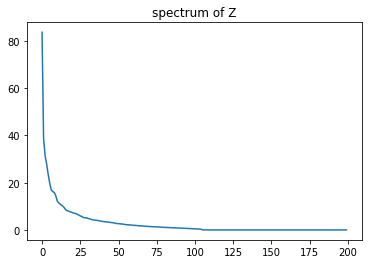

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


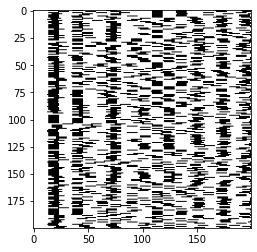

In [20]:
file_path = 'data.p'
df = synthetic_experiment(200, 200, mean_M = 20, tau_star = 10, sigma = 1, r = 10, num_experiment = 100, file_path = file_path, pattern = 'adaptive')

,tau_convex,tau_missing,tau_debias,tau_PCA
count,100.000000,100.000000,100.000000,100.000000
mean,2.532045,36.178024,1.959545,167.595422
std,2.091994,32.003855,0.550153,17.024454
min,0.049773,0.155682,0.746785,121.911865
25%,0.775728,6.594916,1.497087,158.501012
50%,1.926682,29.368352,2.008853,169.402214
75%,3.885157,48.554014,2.379734,181.702729
max,8.723277,112.082477,3.044992,192.116590


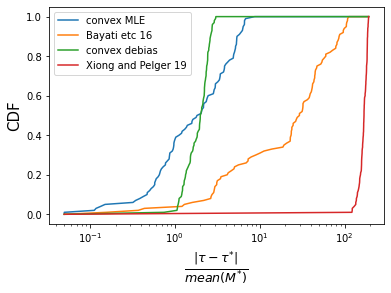

In [86]:
def process_and_plot(file_path, scenario='synthetic'):
    df = pickle.load(open(file_path, 'rb'))
    if (scenario == 'synthetic'):
        algos = ['convex', 'missing', 'ideal', 'debias', 'PCA', 'synthetic_control']
        df_algos = []
        for text in algos:
            if ('tau_'+text in df.columns):
                df_algos.append('tau_'+text)
        df = df / 20
        df = abs(df)
        #df = df / 10
        display(df[df_algos].describe())
    else:
        df = df / 4319.0149
        algos = ['convex', 'missing', 'trivial', 'debias', 'PCA', 'synthetic_control']
        df_algos = []
        for text in algos:
            if ('tau_'+text in df.columns):
                df_algos.append('tau_'+text)
        df = abs(df)
        display(df[df_algos].describe())


    ### plot and process the data

    #### plot the cdf
    

    def plot_cdf(str_name):
        tau = np.array(df[str_name])
        tau = tau[~np.isnan(tau)]
        tau = np.abs(tau)
        tau = sorted(tau)
        cdf = [x/len(tau) for x in range(0,len(tau)+1)]
        cdf.append(1)
        tau = np.concatenate(([xmin], tau))
        tau = np.concatenate((tau, [xmax]))
        #print(tau)
        plt.plot(tau, cdf)

    dic = {'tau_convex': 'convex MLE', 'tau_debias': 'convex debias', 'tau_missing': 'Bayati etc 16', 'tau_PCA': 'Xiong and Pelger 19', 'tau_ideal': 'ideal', 'tau_synthetic_control': 'synthetic control Shah etc 17', 'tau_trivial': 'direct average'}

    xmin = 1e9
    xmax = 0
    legend_name = []
    for text in df_algos:
        xmin = min(xmin, min(np.abs(np.array(df[text]))))
        xmax = max(xmax, max(np.abs(np.array(df[text]))))

    for text in df_algos:
        plot_cdf(text)
        legend_name.append(dic[text])

    plt.ylabel('CDF', fontsize = 15)
    plt.xlabel(r'$\frac{|\tau - \tau^{*}|}{mean(M^{*})}$', fontsize = 18)
    plt.xscale('log')
    plt.legend(legend_name)

file_path = 'data.p'
#file_path = 'data_2020-11-11-05-24.p'
process_and_plot(file_path)

## Quick experiment on the real beer data

In [67]:
df = pd.read_csv(open('data/beer_filter.csv'))
beer_data = np.array(df.drop(['ID'], axis = 1))
beer_data.shape

(393, 245)

In [118]:
def real_data_experiment(M0, suggest_r = 50, tau_range = 1000, num_experiment = 10, file_path = 'data.p', pattern = ''):
    n1 = M0.shape[0]
    n2 = M0.shape[1]
    u, s, vh = np.linalg.svd(M0, full_matrices = False)
    #print(s)
    suggest_lambda = 1.1*s[suggest_r]

    algo_list = ['tau_convex', 'tau_missing', 'tau_debias', 'tau_PCA']
    if (pattern == 'block'):
        algo_list.append('tau_synthetic_control')
    else:
        if (pattern == 'iid'):
            algo_list.append('tau_trivial')
    #store 
    data = np.zeros((num_experiment, len(algo_list)))

    for i in range(num_experiment):
        print('experiments', i)
        tau_star = np.random.rand()*tau_range
        while (True):
            if (pattern == 'adaptive'):
                a = np.random.randint(45)+5
                b = np.random.randint(45)+5
                Z = adpative_treatment_pattern(a, b, M0)
                print(a, b, tau_star)
            else:
                if (pattern == 'iid'):
                    p_treat = np.random.rand()*0.5
                    Z = np.random.rand(n1, n2) <= p_treat
                else: 
                    if (pattern == 'block'):
                        Z = np.zeros((n1, n2))
                        ratio = np.random.rand()*0.8
                        m1 = int(n1*ratio)
                        m2 = int(n2*(1-ratio))
                        Z[:m1, m2:] = 1
                        #m1 = np.random.randint(n1)
                        #m1 = 1
                        #m2 = 
                        #Z[m1, m2:] = 1

            if (np.sum(np.sum(1-Z, axis=0) == 0) > 0 or np.sum(np.sum(1-Z, axis=1) == 0) > 0):
                continue
            break
        print('********sparsity is', np.sum(Z)/Z.size)

        O = M0 + Z * tau_star

        M, tau, tau_debias = tune_convex_algorithm_with_rank(O, Z, suggest_r = suggest_r, suggest_lambda = suggest_lambda)
        M_F, M_oo, tau_error = error_metric(M, tau, M0, tau_star)
        print('Frobenious error {}, entrywise error {}, tau_error {}'.format(M_F, M_oo, tau_error))
        print('tau debias error is {}'.format(tau_debias - tau_star))
        #print('tau is {}, tau_star is {}, tau_debias'.format(tau, tau_star))

        #print('ideal error is {}'.format(ideal_algorithm(E, Z)))

        #covariance_algorithm
        M_c, tau_c = covariance_PCA(O, 1-Z, r=suggest_r)
        M_c_F, M_c_oo, tau_c_error = error_metric(M_c, tau_c, M0, tau_star)
        print('Covariance-PCA algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_c_F, M_c_oo, tau_c_error))

        
        M_m, tau_m = tune_missing_algorithm_with_rank(O, 1-Z, fixed_effects=True, suggest_r=suggest_r, suggest_lambda = suggest_lambda * Z.size / np.sum(1-Z))
        M_m_F, M_m_oo, tau_m_error = error_metric(M_m, tau_m, M0, tau_star)
        print('Missing algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_m_F, M_m_oo, tau_m_error))

        if (pattern == 'block'):
            M_s, tau_s = synthetic_control(O, suggest_r, treat_units=m1, starting_time=m2)
            M_s_F, M_s_oo, tau_s_error = error_metric(M_s, tau_s, M0, tau_star)
            print('Synthetic Control algorithm: Frobenious error {}, entrywise error {}, tau_error {}'.format(M_s_F, M_s_oo, tau_s_error))
        if (pattern == 'iid'):
            tau_t = np.sum(M0*Z)/np.sum(Z) - np.sum(M0*(1-Z))/np.sum(1-Z)
            print('Trivial error'.format(tau_t))

        data[i, 0] = tau - tau_star
        data[i, 1] = tau_m - tau_star
        data[i, 2] = tau_debias - tau_star
        data[i, 3] = tau_c - tau_star
        if (pattern == 'block'):
            data[i, 4] = tau_s - tau_star
        if (pattern == 'iid'):
            data[i, 4] = tau_t
    df = pd.DataFrame(data, columns = algo_list)
    pickle.dump(df, open(file_path, 'wb'))
    return df


#M0 = beer_data
#print(np.mean(M0))
df = real_data_experiment(beer_data, suggest_r = 20, num_experiment = 100, pattern = 'block')
display(df)

thm: Frobenious error 0.034938067369539264, entrywise error 0.24576419434260321, tau_error 3976.2083289062107
35909.84721934545 18
Missing algorithm: Frobenious error 0.003901865200029809, entrywise error 0.07255606886590148, tau_error 50.99509686342154
Synthetic Control algorithm: Frobenious error 0.002373011265272834, entrywise error 0.06678836591934283, tau_error 197.55854533840477
experiments 69
********sparsity is 0.3992314483045126
successful 34502.69290082657 18
Frobenious error 0.00586742236548036, entrywise error 0.0783258670375327, tau_error 788.5209388462962
tau debias error is -174.4818416438212
Covariance-PCA algorithm: Frobenious error 0.7168111782164575, entrywise error 0.9973635284643784, tau_error 5362.025030099883
57430.92377830559 12
Missing algorithm: Frobenious error 0.4058144930236832, entrywise error 0.8868564826497243, tau_error 4222.871657192861
Synthetic Control algorithm: Frobenious error 0.20974669246415797, entrywise error 0.9273417897614191, tau_error 716.

,tau_convex,tau_missing,tau_debias,tau_PCA,tau_synthetic_control
0,383.885871,494.084730,-135.876120,3731.413229,-355.053688
1,1083.674230,4348.729697,-763.623147,5024.418126,-523.582836
2,406.924974,2084.205167,-63.011644,5563.793695,124.922317
3,205.681135,337.919047,-15.240459,5962.446981,-35.627157
4,395.151677,766.620450,0.681110,5542.858676,163.734369
...,...,...,...,...,...
95,450.232371,830.000860,72.780462,5954.536345,260.518487
96,982.326479,4393.965957,-494.480885,5164.267374,379.546508
97,88.194564,-29.369258,-50.628676,4423.237643,-242.808019
98,706.116975,3584.504714,-95.653815,5221.893939,821.469668


,tau_convex,tau_missing,tau_debias,tau_PCA,tau_synthetic_control
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.128482,0.552516,0.044167,1.220009,0.113504
std,0.076603,0.394077,0.067131,0.181920,0.095440
min,0.002381,0.006800,0.000158,0.287182,0.004787
25%,0.089423,0.112784,0.009397,1.159603,0.044350
50%,0.108037,0.491613,0.018119,1.245607,0.077864
75%,0.172122,0.929706,0.032910,1.326294,0.181973
max,0.280614,1.036581,0.334675,1.603706,0.521500


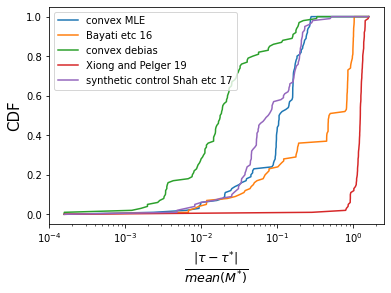

In [120]:
# file_path = 'data_2020-11-18-20-37.p'
# df = pickle.load(open(file_path, 'rb'))
# display(df)
# df1 = df[df['tau_convex'] < 3000]
# display(df1)
# pickle.dump(df1, open('data_2020-11-18-21-35.p', 'wb'))
# file_path = 'data_2020-11-18-21-35.p'
file_path = 'data.p'
process_and_plot(file_path, scenario='real-data')

In [356]:
u, s, vh = np.linalg.svd(Z, full_matrices = False)

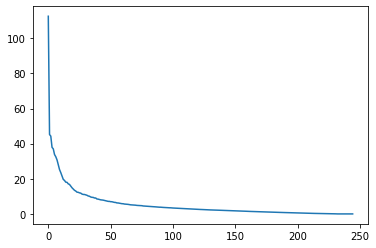

In [357]:
plt.plot(s)

In [495]:
M0 = beer_data
s = np.zeros((100,1))
for i in range(100):
        print('experiments', i)

        #E = np.random.normal(loc = 0, scale = sigma, size = (n1, n2))
        #Z = np.random.rand(n, n) <= p_treat
        #Z = np.zeros((n,n))
        #Z[:int(n/2), :int(n/2)] = 1

        a = np.random.randint(50)+5
        b = np.random.randint(50)+5

        Z = adpative_treatment_pattern(a, b, M0)
#        tau_star = np.random.rand()*tau_range
        print(a, b)
        print('********sparsity is', np.sum(Z)/Z.size)
        s[i] = np.sum(Z)/Z.size

experiments 0
24 21
********sparsity is 0.3281819598068235
experiments 1
34 31
********sparsity is 0.3167367710442956
experiments 2
36 40
********sparsity is 0.3508646206574233
experiments 3
24 30
********sparsity is 0.4009866542036662
experiments 4
22 18
********sparsity is 0.30230046216960066
experiments 5
34 14
********sparsity is 0.2004777483512489
experiments 6
35 7
********sparsity is 0.10554084229111492
experiments 7
6 23
********sparsity is 0.6336708729293244
experiments 8
10 37
********sparsity is 0.6381783247650206
experiments 9
54 35
********sparsity is 0.23551955133198318
experiments 10
23 28
********sparsity is 0.4132523238302955
experiments 11
13 47
********sparsity is 0.6205743366048709
experiments 12
53 11
********sparsity is 0.08849768915199667
experiments 13
22 33
********sparsity is 0.43917536480240954
experiments 14
23 25
********sparsity is 0.383258036038843
experiments 15
9 20
********sparsity is 0.510681829983902
experiments 16
6 22
********sparsity is 0.62253725

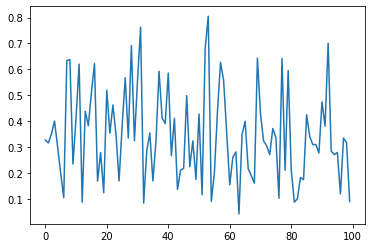

In [497]:
s = s[:100]
plt.plot(s)

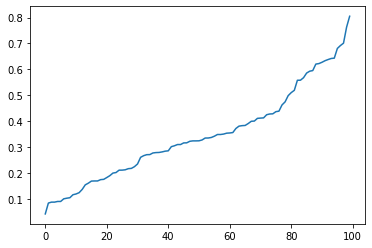

In [499]:
plt.plot(sorted(s))

In [500]:
np.mean(s)

0.3460860985615621